## Modeling and Evaluation
This chapter deals with finding a classification model to exceed the baseline accuracy with the means of gridsearch approach to fine-tuning the hyperparameters. The best result is evaluated in the end.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

pd.set_option('display.max_columns', None)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# (additionally the '\r'-symbols in review_comment_message of orders have been deleted: 39872 and 88584)
ecommerce_csv_path = '../resources/Brazilian_retail/ecommerce_review_score.csv'

In [3]:
df = pd.read_csv(ecommerce_csv_path,
                 lineterminator='\n',
                 parse_dates=['order_estimated_delivery_date', 'order_purchase_date', 
                              'review_creation_date', 'shipping_limit_date'],
                encoding='utf-8')

### E-ecommerce Object
Here, an object of the dataset is created which contains the header, the data and a description for each feature.

In [4]:
import csv 

with open(ecommerce_csv_path, 'r') as f:
    reader = csv.reader(f)
    rows = list(reader)
    
header = rows[0]
data = rows[1:]

In [5]:
def convert_data(data):
    """
    Converting data into correct data type (except for date objects)
    """
    if data.isnumeric():
        return int(data)
    else:
        try:
            return float(data)
        except:
            return str(data)

In [6]:
ecommerce_data = {head: list(convert_data(row[i]) 
                             for row in data) 
                  for i, head in enumerate(header)}

ecommerce_data['features'] = header

In [7]:
ecommerce_data['description'] = {
    'order_id': 'Order unique identifier. An order_id can occur more than once when an order contains various products.',
    'customer_id': 'Key to the orders dataset. Each order has a unique customer_id.',
    'order_estimated_delivery_date': 'Shows the estimated delivery date that was informed to customer at the purchase moment.',
    'customer_unique_id': 'unique identifier of a customer',
    'customer_zip_code_prefix': 'first five digits of customer zip code',
    'customer_city': 'customer city name',
    'customer_state': 'customer state',
    'geolocation_lat_customer': 'latitude of customer location',
    'geolocation_lng_customer': 'longitude of customer location',
    'review_id': 'unique review identifier',
    'review_score': 'Note ranging from 1 to 5 given by the customer on a satisfaction survey.',
    'review_comment_message': 'Comment message from the review left by the customer, in Portuguese.',
    'review_creation_date': 'Shows the date in which the satisfaction survey was sent to the customer.',
    'payment_sequential': 'A customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments. It will show the total number of sequences.',
    'payment_type': 'method of payment chosen by the customer',
    'payment_installments': 'number of installments chosen by the customer',
    'payment_value': 'transaction value',
    'order_item': 'amount of ordered products',
    'product_id': 'product unique identifier',
    'seller_id': 'seller unique identifier',
    'shipping_limit_date': 'Shows the seller shipping limit date for handling the order over to the logistic partner.',
    'price': 'item price',
    'freight_value': 'item freight value item (if an order has more than one item the freight value is splitted between items)',
    'product_category_name': 'root category of product, in Portuguese',
    'product_name_lenght': 'number of characters extracted from the product name',
    'product_description_lenght': 'number of characters extracted from the product description',
    'product_photos_qty': 'number of product published photos',
    'product_weight_g': 'product weight measured in grams',
    'product_length_cm': 'product length measured in centimeters',
    'product_height_cm': 'product height measured in centimeters',
    'product_width_cm': 'product width measured in centimeters',
    'geolocation_lat_seller': 'Latitude of seller location. The dataset doesn\'t provide full information about the exact position of a seller, but only the seller zip code information. Therefore a random latitude of a customer was chosen which lives in the same city.',
    'geolocation_lng_seller': 'Longitude of seller location. The dataset doesn\'t provide full information about the exact position of a seller, but only the seller zip code information. Therefore a random longitude of a customer was chosen which lives in the same city.',
    'seller_zip_code_prefix': 'first 5 digits of seller zip code',
    'seller_city': 'seller city name',
    'seller_state': 'seller state',
    'delivery_weight': 'total delivery weight',
    'order_approved_diff': 'time past in hours between ordering and order has been approved',
    'order_purchase_date': 'date when order was purchased',
    'order_purchase_day': 'day when order was purchased',
    'order_purchase_time': 'Shows the purchase time.',
    'carrier_diff': 'time past in hours till carrier started with the delivery',
    'order_diff': 'time past in days till customer received its order since the order',
    'review_time': 'Shows the hour when the review arrived.'
}

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100645 entries, 0 to 100644
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100645 non-null  object        
 1   customer_id                    100645 non-null  object        
 2   order_estimated_delivery_date  100645 non-null  datetime64[ns]
 3   customer_unique_id             100645 non-null  object        
 4   customer_zip_code_prefix       100645 non-null  int64         
 5   customer_city                  100645 non-null  object        
 6   customer_state                 100645 non-null  object        
 7   geolocation_lat_customer       100645 non-null  float64       
 8   geolocation_lng_customer       100645 non-null  float64       
 9   review_id                      100645 non-null  object        
 10  review_score                   100645 non-null  int64         
 11  

In [9]:
# NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
import string
import emoji

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, average_precision_score

# classes for pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, FeatureUnion #, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline

# classes for modelling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import joblib

np.random.seed(0)

### Baseline
A model can only be accepted when it exceeds at least the baseline.

In [10]:
baseline = df['review_score'].value_counts(normalize=True).max()
baseline

0.5825525361418848

### Data for modeling
Some of the features of the dataset aren't representative for modeling, especially if they contain unique values for each observation. Accordingly, features with indivudal id's, longitude and latitude data or with fully timestamps have been neglected.

In [11]:
X = df.loc[:, ~df.columns.isin(['order_id', 'customer_id', 'customer_unique_id', 
                                'review_id', 'geolocation_lat_customer', 
                                'geolocation_lng_customer', 'geolocation_lat_seller',
                                'geolocation_lng_seller', 'customer_zip_code_prefix',
                                'seller_zip_code_prefix', 'order_estimated_delivery_date',
                                'review_creation_date', 'shipping_limit_date',
                                'order_purchase_date', 'delivery_weight'])].copy()
y = X.pop('review_score')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y, shuffle=True)

In [12]:
y_train.value_counts()

5    46905
4    15611
1     8603
3     6756
2     2641
Name: review_score, dtype: int64

In [13]:
# sample_num = y_train.value_counts()[4]
# sample_num

In [14]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

In [15]:
# ros = RandomOverSampler(random_state=1, sampling_strategy={2: sample_num,
#                                                            3: sample_num,
#                                                            1: sample_num})
# ros = RandomOverSampler(random_state=1, sampling_strategy={2: 30000,
#                                                            3: 30000,
#                                                            1: 30000})
# rus = RandomUnderSampler(random_state=1, sampling_strategy={5: sample_num})

# X_over_sampled, y_over_sampled = ros.fit_sample(X_train, y_train)
# X_train, y_train = rus.fit_sample(X_over_sampled, y_over_sampled)
# X_train, y_train = ros.fit_sample(X_train, y_train)

### Review comments analysis
The following steps show the preparation for the Natural Language processing approach and some visual characteristics of the review comments. 

In [16]:
def text_process(txt):
    """
    The function takes in a text and returns a list with 'cleaned words'. 
    It converts the words in lower case letters, it seperates emoticons if there are used several in a row and
    it removes punctuations and stopwords.
    
    Parameters:
    txt (string): text
    
    Returns:
    (list): cleaned text
    """
    cleaned_txt = ''.join([char + ' ' if char in emoji.UNICODE_EMOJI 
                           else char.lower() if char not in string.punctuation 
                           else '' for char in txt])
  
    return [word for word in cleaned_txt.split() if word.lower() not in stopwords.words('portuguese')]

In [17]:
# counting individual words
cvec = CountVectorizer(analyzer=text_process).fit(X_train['review_comment_message'])
print(f'There are {len(cvec.vocabulary_)} individual words in the messages.')

There are 16874 individual words in the messages.


In [18]:
# to translate specific words in english
from googletrans import Translator

translator = Translator(service_urls=[
      'translate.google.com',
      'translate.google.co.kr',
    ])

In [19]:
# translation = []
# for word in word_list.index[:10]:
#     translation.append(translator.translate(word).text)
# translation

The part of the dataframe below shows the top 10 most common words with their frequency and the translation in english.

In [20]:
# showing the top most common words 
occurrences = cvec.transform(X_train['review_comment_message']).sum(axis=0)
words = cvec.get_feature_names()
word_list = pd.DataFrame(occurrences, columns=words).transpose().rename(columns={0: 'frequency'}) \
                                                    .sort_values(by='frequency', ascending=False) \
                                                    .reset_index() 
word_list.rename(columns={'index': 'word'}, inplace=True)

word_list['translation'] = word_list[['word']][:10] \
                                    .apply(lambda x: translator.translate(x[0]).text, axis=1)
word_list[:10]

,word,frequency,translation
0,nomessage,47042,nomessage
1,produto,14348,product
2,prazo,6560,deadline
3,entrega,5200,delivery
4,antes,4530,before
5,chegou,4522,has arrived
6,recebi,4439,I received
7,bom,3659,good
8,recomendo,3407,I recommend
9,entregue,3195,delivered


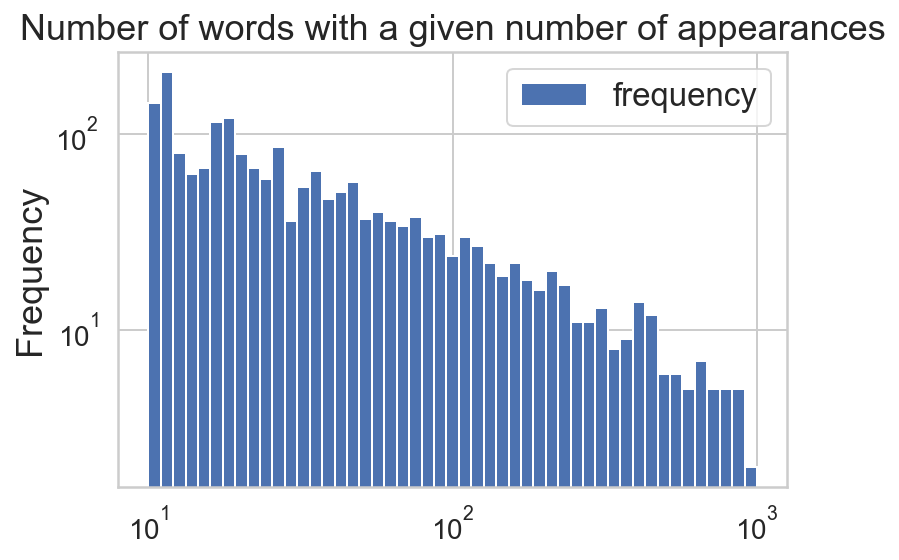

In [21]:
word_list.plot(kind='hist',
               bins=np.logspace(1, 3, 50),
               loglog=True,
               title='Number of words with a given number of appearances',
               fontsize=14)
plt.show()

The review comments should be well distinguishable by each different review score to be a predictive feature element. To get a rough overview, the sparsity pattern of the word matrix of representing which words are used for each observation is plotted in the image below. 

The matrix includes the review messages of the training set ordered by the review score. The horizontal lines indicates the starting point of the next review score from 2 on the top (<span style='color:red'>red</span>) to 5 on the bottom (<span style='color:#FF00FF'>pink</span>). There are used a lot more different words for bad reviews. Even if the resolution of the plot doesn't show the accurate picture, it seem's like that a few more words are used in the overall document which should be added to the stopwords list.

In [22]:
# getting the first index for each review_score 
message_list = pd.concat([X_train, y_train], axis=1).sort_values(by='review_score')[['review_comment_message', 'review_score']] \
                      .reset_index(drop=True)
message_score_2_idx = message_list[message_list['review_score'] == 2].index[0]
message_score_3_idx = message_list[message_list['review_score'] == 3].index[0]
message_score_4_idx = message_list[message_list['review_score'] == 4].index[0]
message_score_5_idx = message_list[message_list['review_score'] == 5].index[0]

In [23]:
cvec_mat = cvec.transform(pd.concat([X_train, y_train], axis=1).sort_values(by='review_score')['review_comment_message'])

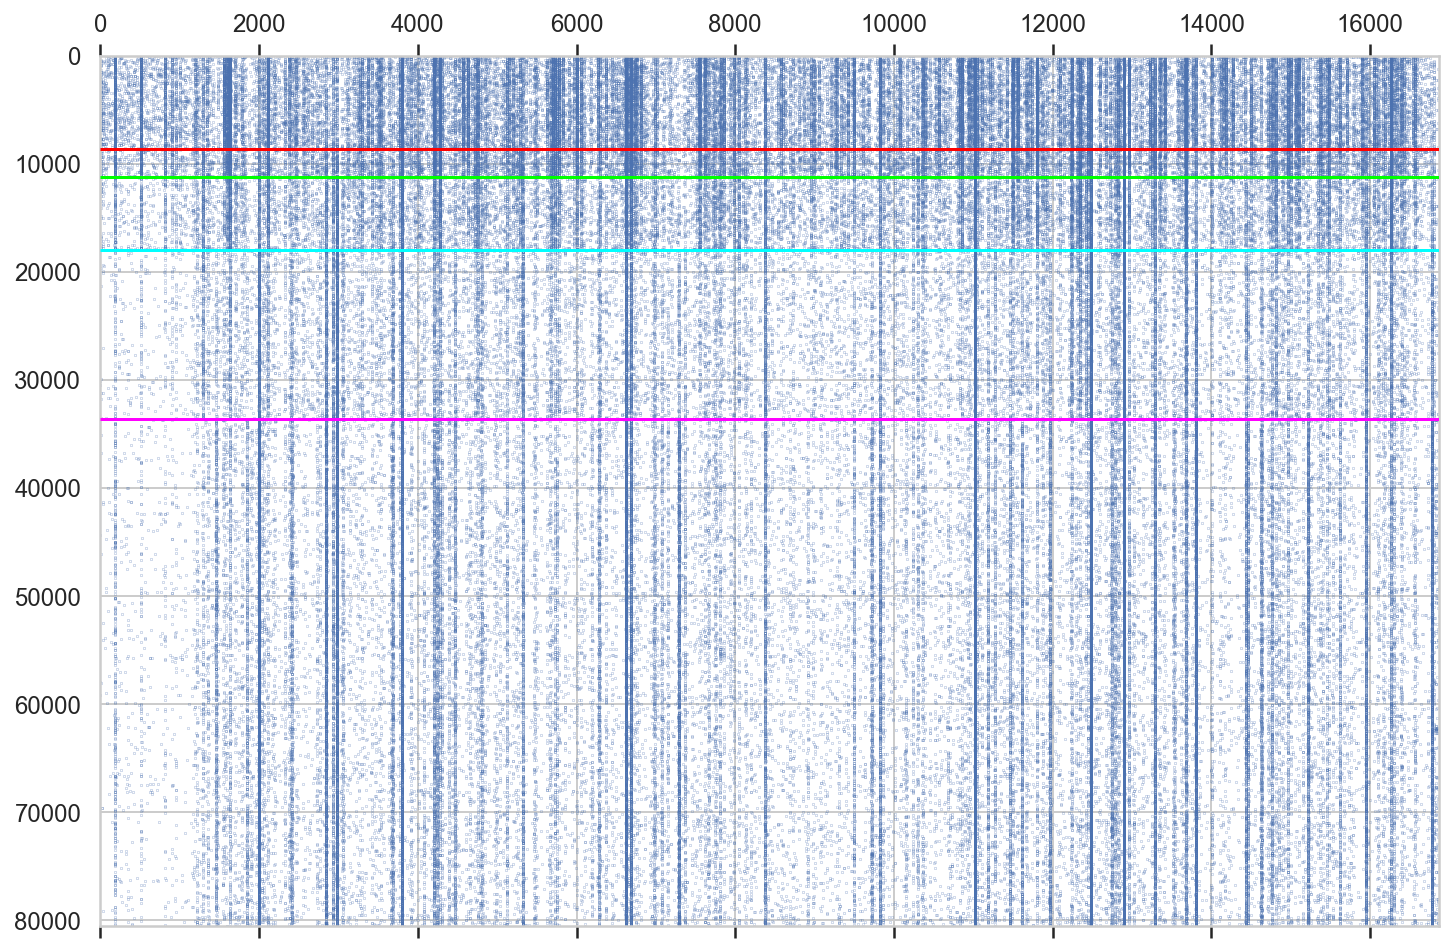

In [24]:
plt.figure(figsize=(12, 8))
plt.spy(cvec_mat, markersize=0.001, aspect='auto')
plt.hlines(y=message_score_2_idx, xmin=0, xmax=len(word_list), colors='red', zorder=10)
plt.hlines(y=message_score_3_idx, xmin=0, xmax=len(word_list), colors='#00FF00', zorder=10)
plt.hlines(y=message_score_4_idx, xmin=0, xmax=len(word_list), colors='#00FFFF', zorder=10)
plt.hlines(y=message_score_5_idx, xmin=0, xmax=len(word_list), colors='#FF00FF', zorder=10)
plt.show()

### Modeling
The next section covers the modeling part. First, the data are prepared before applying machine learning models. Numerical features are standardized and categorical features transformed in the well-fitting format with the `OneHotEncoder`. The Natural Language Processing for the `review_comment_message` feature is done with the `TfidfVectorizer`. As parameters were used a maximal amounts of features of 10000 and the `ngram_range` holds only one or two words.

Following classification models were applied with the `GridSearchCV` approach:
- `LogisticRegression`
- `RandomForestClassifier`
- `SGDClassifier`
- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `SVC`
- `BaggingClassifier` with `KNeighborsClassifier` and `DecisionTreeClassifier`

Annotation:<br>
For all the models the imbalanced classes were used, because up- or downscaling didn't lead to better results. Probably, because of implementing the RandomOverSampler and RandomUnderSampler in a wrong way. Furthermore, the PCA couldn't be applied of local computation reasons that's why the models needs to be computed by cloud computing in the future.

In [25]:
# printing out the result of models (model name, best cv score, test score and best grid search parameters)
output = \
"""
------------------------------------------------
model: {name}
cv score: {cv_score}
test score: {test_score}
best parameters: 
{params}
------------------------------------------------
"""

def print_gridsearch_results(*gs):
    for model in gs:
        print(output.format(name = type(model.best_estimator_).__name__,
                            cv_score = round(model.best_score_, 4),
                            test_score = round(model.score(X_test, y_test), 4),
                            params = model.best_params_)
        )

In [26]:
# preparing the data
features_text = 'review_comment_message'
features_categorical = [c for c in X.columns if X[c].dtypes == 'O' and c != features_text or 
                        c in ['review_time', 'order_purchase_time']]
features_numerical = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c].dtype) and 
                      c not in ['order_purchase_time', 'review_time']]

In [27]:
# caching = joblib.Memory('../Memory/')

In [28]:
# class ToDenseTransformer(BaseEstimator, TransformerMixin):

#     def transform(self, X, y=None, **fit_params):
#         return X.todense()

#     def fit(self, X, y=None, **fit_params):
#         return self

In [29]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('portuguese'),
                        max_df=0.6,
                        max_features=10000,
                        analyzer=text_process,
                        ngram_range=(1,2)
                        )

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_transformer = Pipeline(steps=[
    ('tfidf', tfidf)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numerical),
        ('cat', categorical_transformer, features_categorical),
        ('text', text_transformer, features_text)],
    remainder='passthrough')

In [30]:
# pca = PCA(.8)
# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                        ('dense', ToDenseTransformer()),
#                        ('pca', pca)])

# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                        ('under', rus), 
#                        ('over', ros)])

pipe = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [32]:
clf_params = {
    'solver': 'liblinear', 
    'multi_class': 'ovr',
    'max_iter': 5000,
    'class_weight': 'balanced'
}

grid_params = {
    'C': [0.001, 0.1, 1, 10, 50],
    'penalty': ['l1', 'l2']
}  

model = LogisticRegression(**clf_params)

gs_lr = GridSearchCV(model, 
                     grid_params, 
                     cv=kf, 
                     scoring='accuracy', 
                     n_jobs=5,
                     verbose=10)

In [33]:
# gs_lr.fit(X_train, y_train)
gs_lr = joblib.load('joblibs/gridsearch_lr.jlib')

In [34]:
# kf = KFold(n_splits=5, shuffle=True, random_state=1)

# clf_params = {
#     'solver': 'liblinear', 
#     'multi_class': 'ovr',
#     'max_iter': 5000,
#     'class_weight': 'balanced'
# }

# clf_lr = LogisticRegression(**clf_params)

# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                        ('classifier', clf_lr),
#                       ]) #, memory=caching)
    
# params = {
#     #'preprocessor__text__tfidf__max_df': [0.3, 0.6, 1.0],
#     'classifier__C': [0.001, 0.1, 1, 10, 50],
#     'classifier__penalty': ['l1', 'l2']
# }  


# gs_lr = GridSearchCV(pipe, params, verbose=10, n_jobs=-1, cv=kf, scoring='accuracy')
# gs_lr.fit(X_train, y_train)

In [35]:
print('Logistic regression')
print(f'cv score: {gs_lr.best_score_}')
print(f'test score: {gs_lr.score(X_test, y_test)}')

Logistic regression
cv score: 0.6173182270282597
test score: 0.6198519548909533


In [36]:
# done
# joblib.dump(gs_lr, 'joblibs/gridsearch_lr.jlib')

In [37]:
clf_rf = RandomForestClassifier(class_weight='balanced')
    
grid_params = {
    'max_samples': np.linspace(0.8, 1.0, 3),  # 1.0 too high
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': np.arange(1, 3)
}  

gs_rf = GridSearchCV(clf_rf, grid_params, verbose=10, n_jobs=4, cv=kf, scoring='accuracy')

In [38]:
# clf_rf = RandomForestClassifier(class_weight='balanced')

# pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                        ('classifier', clf_rf),
#                       ])
    
# params = {
#     #'preprocessor__text__tfidf__sublinear_tf': [True, False],
#     'preprocessor__text__tfidf__max_df': [0.3, 0.6, 1.0],
#     'classifier__max_samples': np.linspace(0.8, 1.0, 3),
#     'classifier__min_impurity_decrease': [0.0, 0.1],
#     'classifier__min_samples_leaf': np.arange(1, 3)
# }  


# gs_rf = GridSearchCV(pipe, params, verbose=10, n_jobs=-1, cv=kf, scoring='accuracy')

In [39]:
# gs_rf.fit(X_train, y_train)
gs_rf = joblib.load('joblibs/gridsearch_rf.jlib')

In [40]:
print('RandomForest Classifier')
print(f'cv score: {gs_rf.best_score_}')
print(f'test score: {gs_rf.score(X_test, y_test)}')

RandomForest Classifier
cv score: 0.6513488452180001
test score: 0.6543792538129067


In [41]:
# done
# joblib.dump(gs_rf, 'joblibs/gridsearch_rf.jlib')

In [43]:
clf_sgdc = SGDClassifier(max_iter=2000)

grid_params = {
    'alpha': [0.0001, 0.1, 0.5],
    'l1_ratio': np.linspace(0.0001, 0.5, 3),
    'loss': ['hinge', 'squared_hinge']
}  

gs_sgdc = GridSearchCV(clf_sgdc, grid_params, verbose=10, n_jobs=4, cv=kf, scoring='accuracy')

In [44]:
# gs_sgdc.fit(X_train, y_train)
gs_sgdc = joblib.load('joblibs/gridsearch_sgdc.jlib')

In [45]:
print('SGDC Classifier')
print(f'cv score: {gs_sgdc.best_score_}')
print(f'test score: {gs_sgdc.score(X_test, y_test)}')
print(f'best parameters: {gs_sgdc.best_params_}')

SGDC Classifier
cv score: 0.6527771227380963
test score: 0.6519449550399921
best parameters: {'alpha': 0.0001, 'l1_ratio': 0.0001, 'loss': 'hinge'}


In [46]:
# done
# joblib.dump(gs_sgdc, 'joblibs/gridsearch_sgdc.jlib')

In [47]:
clf_dt = DecisionTreeClassifier()

grid_params = {
    'max_depth': [3, 5, None] ,
    'max_features': [None, 'auto', 'sqrt']
}  

gs_dt = GridSearchCV(clf_dt, grid_params, verbose=10, n_jobs=4, cv=kf, scoring='accuracy')

In [48]:
# gs_dt.fit(X_train, y_train)
gs_dt = joblib.load('joblibs/gridsearch_dt.jlib')

In [49]:
print('DecisionTree Classifier')
print(f'cv score: {gs_dt.best_score_}')
print(f'test score: {gs_dt.score(X_test, y_test)}')

DecisionTree Classifier
cv score: 0.6262978971159302
test score: 0.6272542103432858


In [50]:
# done
# joblib.dump(gs_dt, 'joblibs/gridsearch_dt.jlib')

In [51]:
clf_knn = KNeighborsClassifier()

grid_params = {
    'n_neighbors': [5, 120, 500],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}  


gs_knn = GridSearchCV(clf_knn, grid_params, verbose=10, n_jobs=4, cv=kf, scoring='accuracy')

In [52]:
# gs_knn.fit(X_train, y_train)
gs_knn = joblib.load('joblibs/gridsearch_knn.jlib')

In [53]:
print('KNeighbors Classifier')
print(f'cv score: {gs_knn.best_score_}')
print(f'test score: {gs_knn.score(X_test, y_test)}')

KNeighbors Classifier
cv score: 0.5957822676171919
test score: 0.5960554423965423


In [54]:
# joblib.dump(gs_knn, 'joblibs/gridsearch_knn.jlib')

In [55]:
clf_svc = SVC(gamma='scale', class_weight='balanced')

grid_params = {
    'C': [0.01],  #[0.01, 0.1, 0.9],
    'kernel': ['linear', 'rbf']
}  

gs_svc = GridSearchCV(clf_svc, grid_params, verbose=10, n_jobs=4, cv=kf, scoring='accuracy')

In [56]:
# gs_svc.fit(X_train, y_train)
gs_svc = joblib.load('joblibs/gridsearch_svc.jlib')

In [57]:
print('SVC Classifier')
print(f'cv score: {gs_svc.best_score_}')
print(f'test score: {gs_svc.score(X_test, y_test)}')
print(f'best parameters: {gs_svc.best_params_}')

SVC Classifier
cv score: 0.4574867379915416
test score: 0.4614734959511153
best parameters: {'C': 0.01, 'kernel': 'linear'}


In [58]:
# joblib.dump(gs_svc, 'joblibs/gridsearch_svc.jlib')

In [59]:
clf_bagging = BaggingClassifier(base_estimator=KNeighborsClassifier(metric='euclidean',
                                                                    n_neighbors=50,
                                                                    weights='distance'),
                                n_estimators=10)

grid_params = {
    'max_samples': np.linspace(0.4, 0.6, 2),
    'max_features': [0.5, 0.6]
}  


gs_bagging_knn = GridSearchCV(clf_bagging, grid_params, verbose=10,  n_jobs=4, cv=kf, scoring='accuracy')

In [60]:
# gs_bagging_knn.fit(X_train, y_train)
gs_bagging_knn = joblib.load('joblibs/gridsearch_bagging_knn.jlib')

In [61]:
print('Bagging Classifier with KNN')
print(f'cv score: {gs_bagging_knn.best_score_}')
print(f'test score: {gs_bagging_knn.score(X_test, y_test)}')

Bagging Classifier with KNN
cv score: 0.5951488722669228
test score: 0.5883054299766506


In [62]:
# joblib.dump(gs_bagging_knn, 'joblibs/gridsearch_bagging_knn.jlib')

In [63]:
clf_bagging = BaggingClassifier(base_estimator=clf_dt,
                                n_estimators=10)

grid_params = {
    #'max_samples': np.linspace(0.8, 1.0, 2),
    'max_features': [0.5, 0.9]
}  


gs_bagging_dt = GridSearchCV(clf_bagging, grid_params, verbose=10, n_jobs=5, cv=kf, scoring='accuracy')

In [64]:
# gs_bagging_dt.fit(X_train, y_train)
gs_bagging_dt = joblib.load('joblibs/gridsearch_bagging_dt.jlib')

In [65]:
print('Bagging Classifier with Decisiontree')
print(f'cv score: {gs_bagging_dt.best_score_}')
print(f'test score: {gs_bagging_dt.score(X_test, y_test)}')

Bagging Classifier with Decisiontree
cv score: 0.6361096192762321
test score: 0.6364449302002086


In [66]:
# joblib.dump(gs_bagging_dt, 'joblibs/gridsearch_bagging_dt.jlib')

In [67]:
model_lr = joblib.load('gridsearch_lr.jlib')
model_rf = joblib.load('gridsearch_rf.jlib')
model_knn = joblib.load('gridsearch_knn.jlib')
model_sgdc = joblib.load('gridsearch_sgdc.jlib')
model_dt = joblib.load('gridsearch_dt.jlib')
model_bagging_knn = joblib.load('gridsearch_bagging_knn.jlib')
model_bagging_dt = joblib.load('gridsearch_bagging_dt.jlib')

In [68]:
# printing model results
print_gridsearch_results(model_lr, model_rf, model_knn, model_sgdc, model_dt, model_bagging_knn, model_bagging_dt)


------------------------------------------------
model: LogisticRegression
cv score: 0.6173
test score: 0.6199
best parameters: 
{'C': 0.1, 'penalty': 'l2'}
------------------------------------------------


------------------------------------------------
model: RandomForestClassifier
cv score: 0.6513
test score: 0.6544
best parameters: 
{'max_samples': 0.9, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1}
------------------------------------------------


------------------------------------------------
model: KNeighborsClassifier
cv score: 0.5958
test score: 0.5961
best parameters: 
{'metric': 'euclidean', 'n_neighbors': 120, 'weights': 'distance'}
------------------------------------------------


------------------------------------------------
model: SGDClassifier
cv score: 0.6528
test score: 0.6519
best parameters: 
{'alpha': 0.0001, 'l1_ratio': 0.0001, 'loss': 'hinge'}
------------------------------------------------


------------------------------------------------
model

## Evaluation

The stochastic gradient descent classifier (SGDC) leads to the best score regarding to the accuaracy. Now, the results according to the individual classes are been analyzed.

In [69]:
# the hinge loss function gives a linear SVM
model_sgdc.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.0001, 'loss': 'hinge'}

In [70]:
model = model_sgdc
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6519449550399921


In [71]:
# classes
model_sgdc.classes_

array([1, 2, 3, 4, 5])

### Confusion matrix and classification report
The confusion matrix shows the performance of the model to classify labels correctly. <br>
For the training set the model predicts for classes two to five the class five proportionaly the most often. The precision scores are the highest for the classes in the middle whereas the recall scores are the highest for the classes one and five. On the other hand the middle classes have very poor recall results and the precisions results are lower for the outer classes. <br>
But also for the classes two and three the class one is predicted more often than the actual true class. 

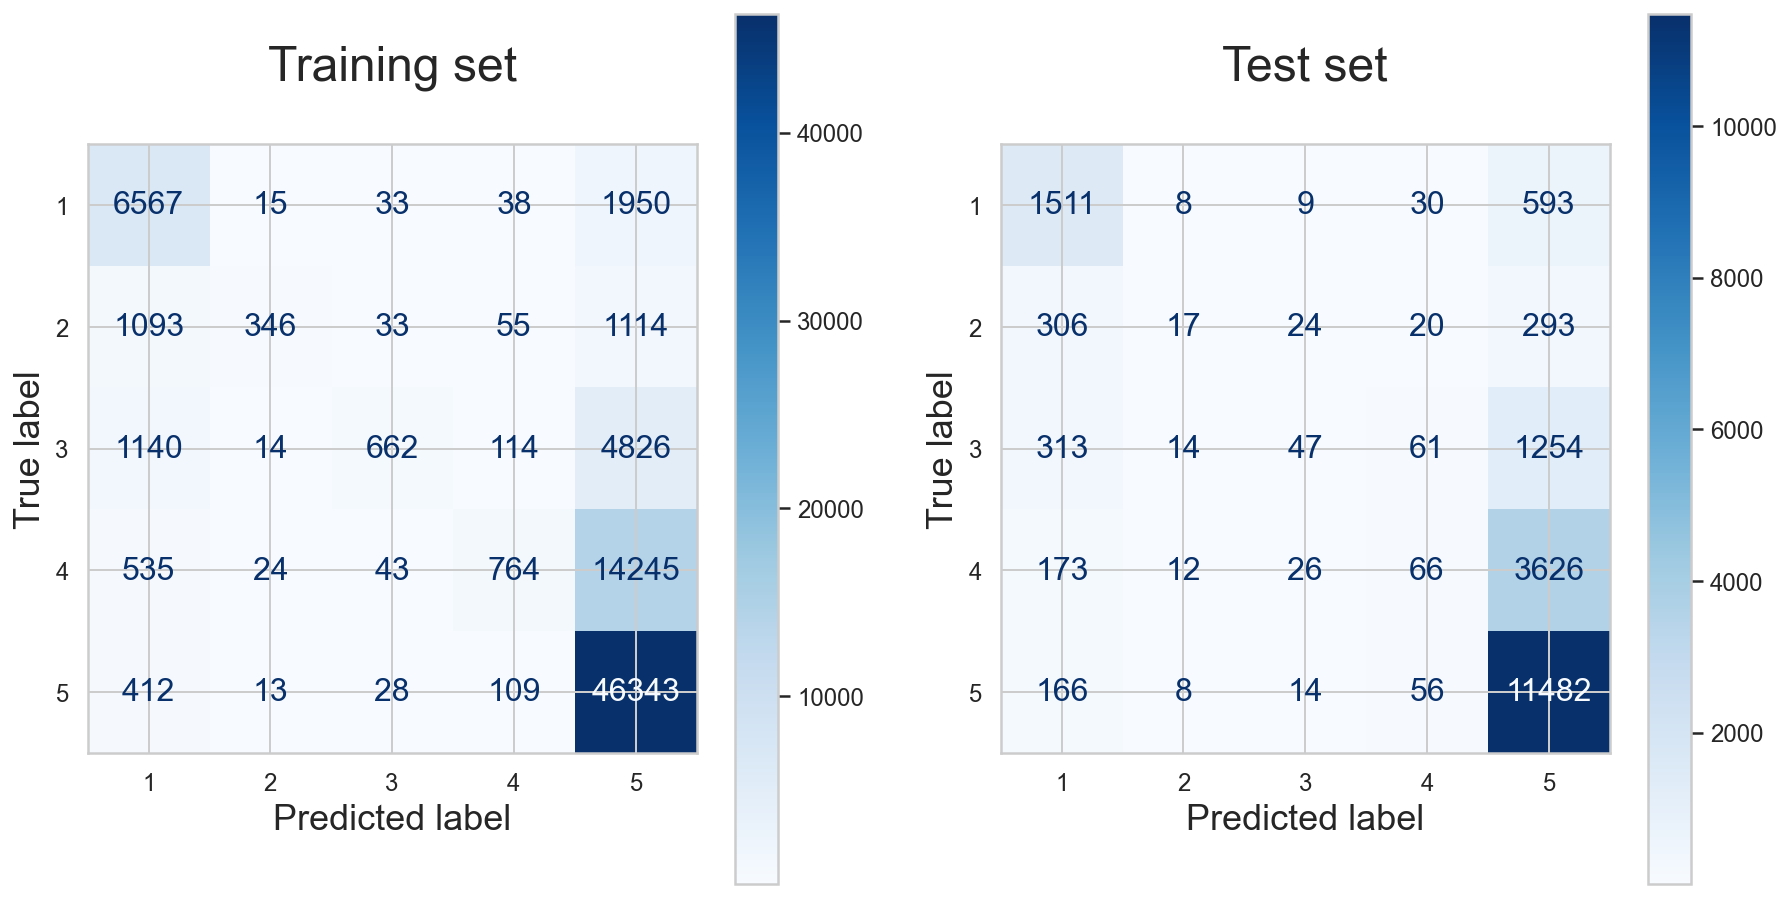

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
plot_confusion_matrix(model, X_train, y_train, labels=[1,2,3,4,5], cmap='Blues', ax=ax[0])
plot_confusion_matrix(model, X_test, y_test, labels=[1, 2, 3, 4, 5], cmap='Blues', ax=ax[1])

for axes in ax:
    for text in axes.texts:
            text.set_size(16)
            
ax[0].set_title('Training set\n', fontsize=24)
ax[1].set_title('Test set\n', fontsize=24)

plt.show()

In [73]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [74]:
# classification report for training set
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           1       0.67      0.76      0.72      8603
           2       0.84      0.13      0.23      2641
           3       0.83      0.10      0.18      6756
           4       0.71      0.05      0.09     15611
           5       0.68      0.99      0.80     46905

    accuracy                           0.68     80516
   macro avg       0.75      0.41      0.40     80516
weighted avg       0.70      0.68      0.58     80516



In [75]:
# classifcation report for test set
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.61      0.70      0.65      2151
           2       0.29      0.03      0.05       660
           3       0.39      0.03      0.05      1689
           4       0.28      0.02      0.03      3903
           5       0.67      0.98      0.79     11726

    accuracy                           0.65     20129
   macro avg       0.45      0.35      0.32     20129
weighted avg       0.55      0.65      0.54     20129



In [76]:
# intercepts
model.best_estimator_.intercept_

array([-1.00455382, -1.30861801, -1.30948841, -1.39747599, -0.0411506 ])

In [77]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 5))

In [78]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

### Precision Recall Curve
The precision recall curve shows a big difference between the training and test set. Even with high thresholds in the test set the classes 2 to 4 can't reach a high recall score. 

In [79]:
from sklearn.calibration import CalibratedClassifierCV

In [80]:
model_sgdc.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.0001, 'loss': 'hinge'}

In [81]:
# sgdc classifier with loss 'hinge' doesn't have probability estimates
calibrator = CalibratedClassifierCV(model_sgdc.best_estimator_, cv='prefit')
model_sgdc_cal = calibrator.fit(X_train, y_train)

In [82]:
y_train_pred_prob = model_sgdc_cal.predict_proba(X_train)
y_test_pred_prob = model_sgdc_cal.predict_proba(X_test)

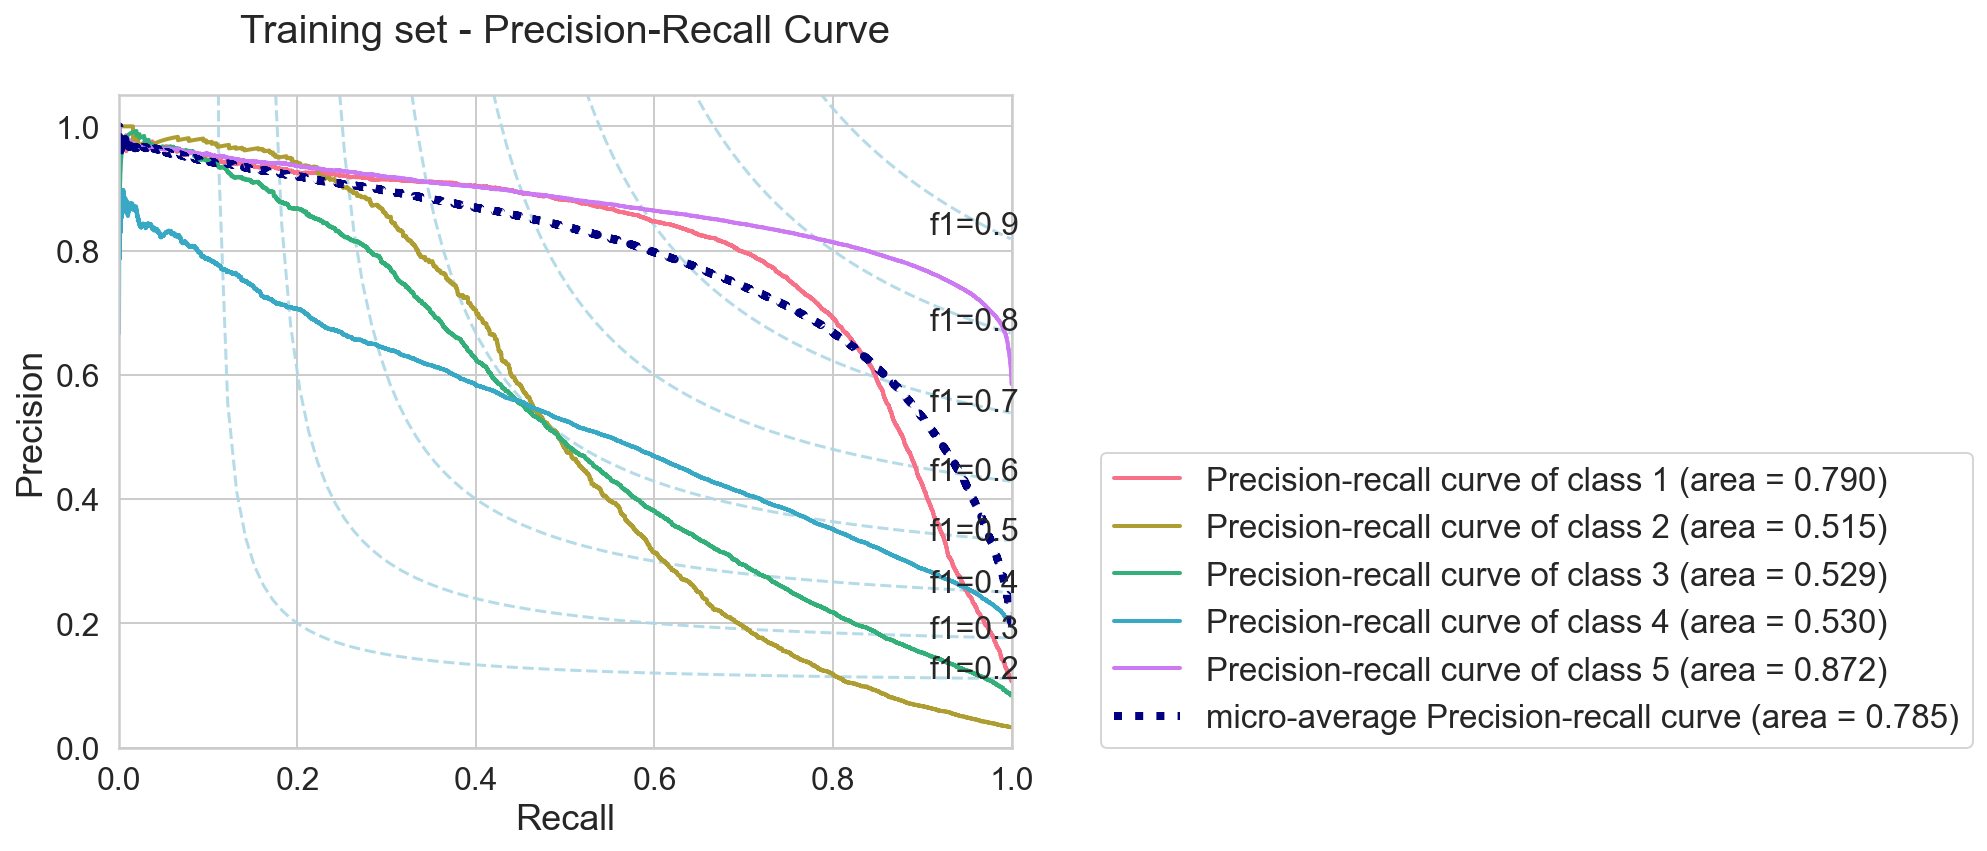

In [83]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_train, y_train_pred_prob, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax,
                       title='Training set - Precision-Recall Curve\n')
ax.legend(loc=[1.1,0])
plt.show()

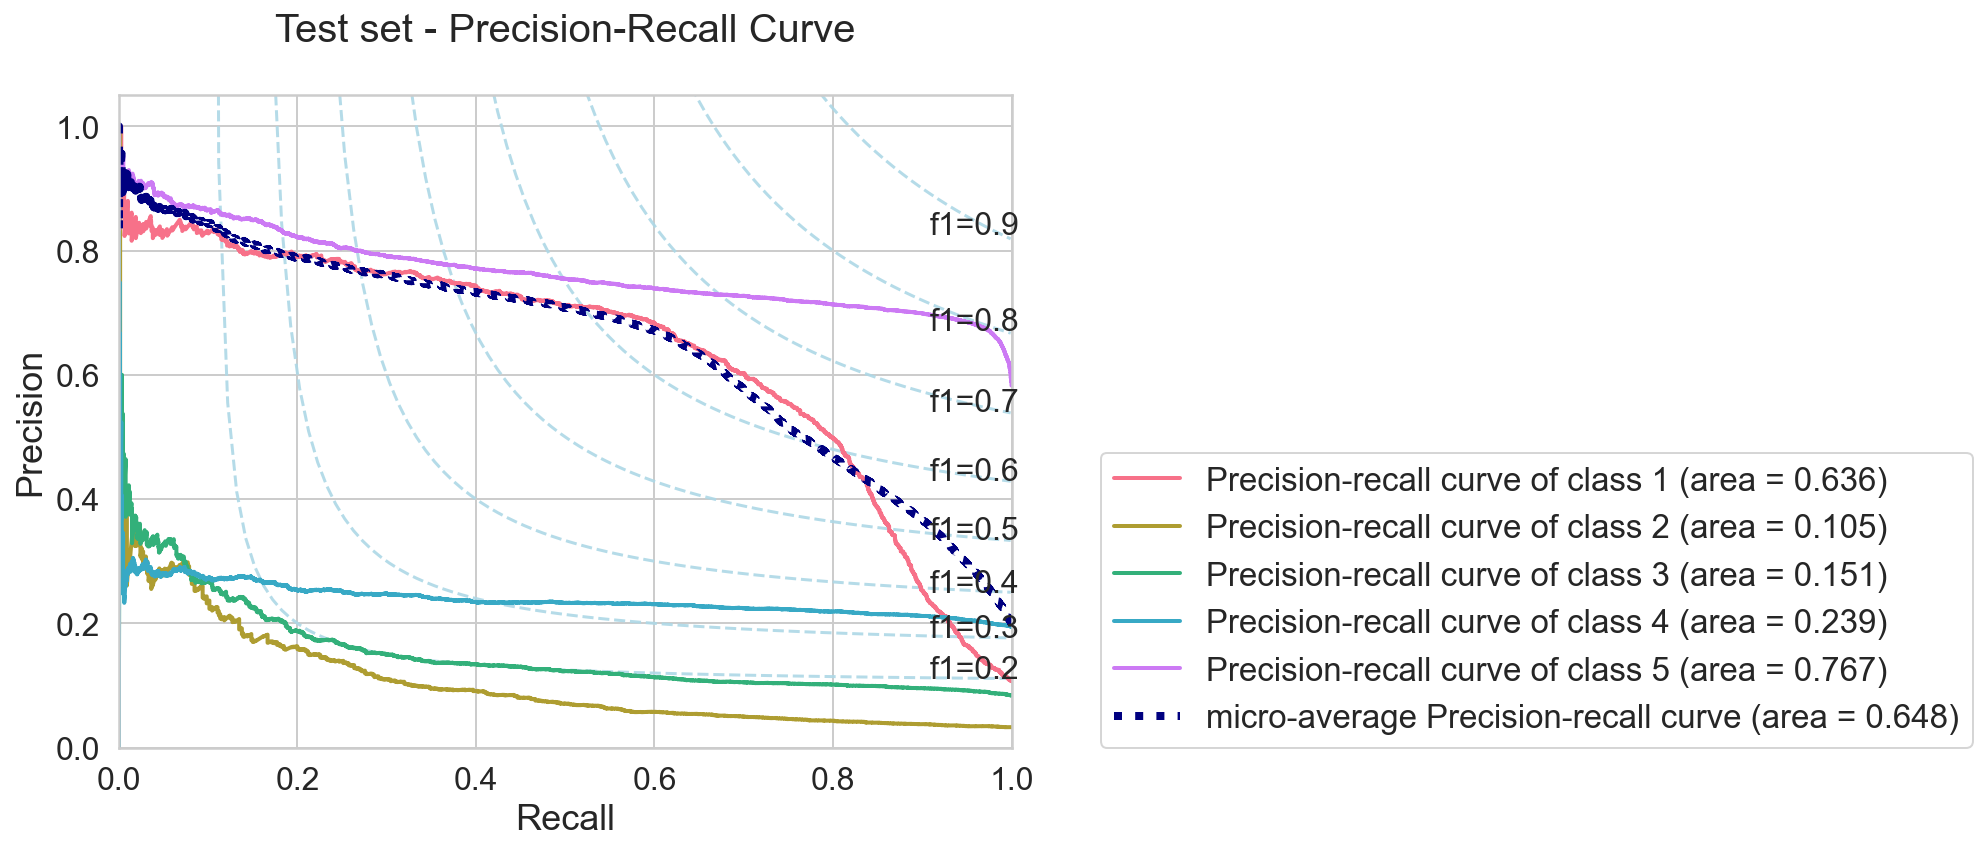

In [84]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, y_test_pred_prob, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax,
                       title='Test set - Precision-Recall Curve\n')
ax.legend(loc=[1.1,0])
plt.show()

### Receiver operating characterstic (ROC) curve
The ROC curve shows a better performance for the training set than for the test set. The class 1 shows the best classification performance. 

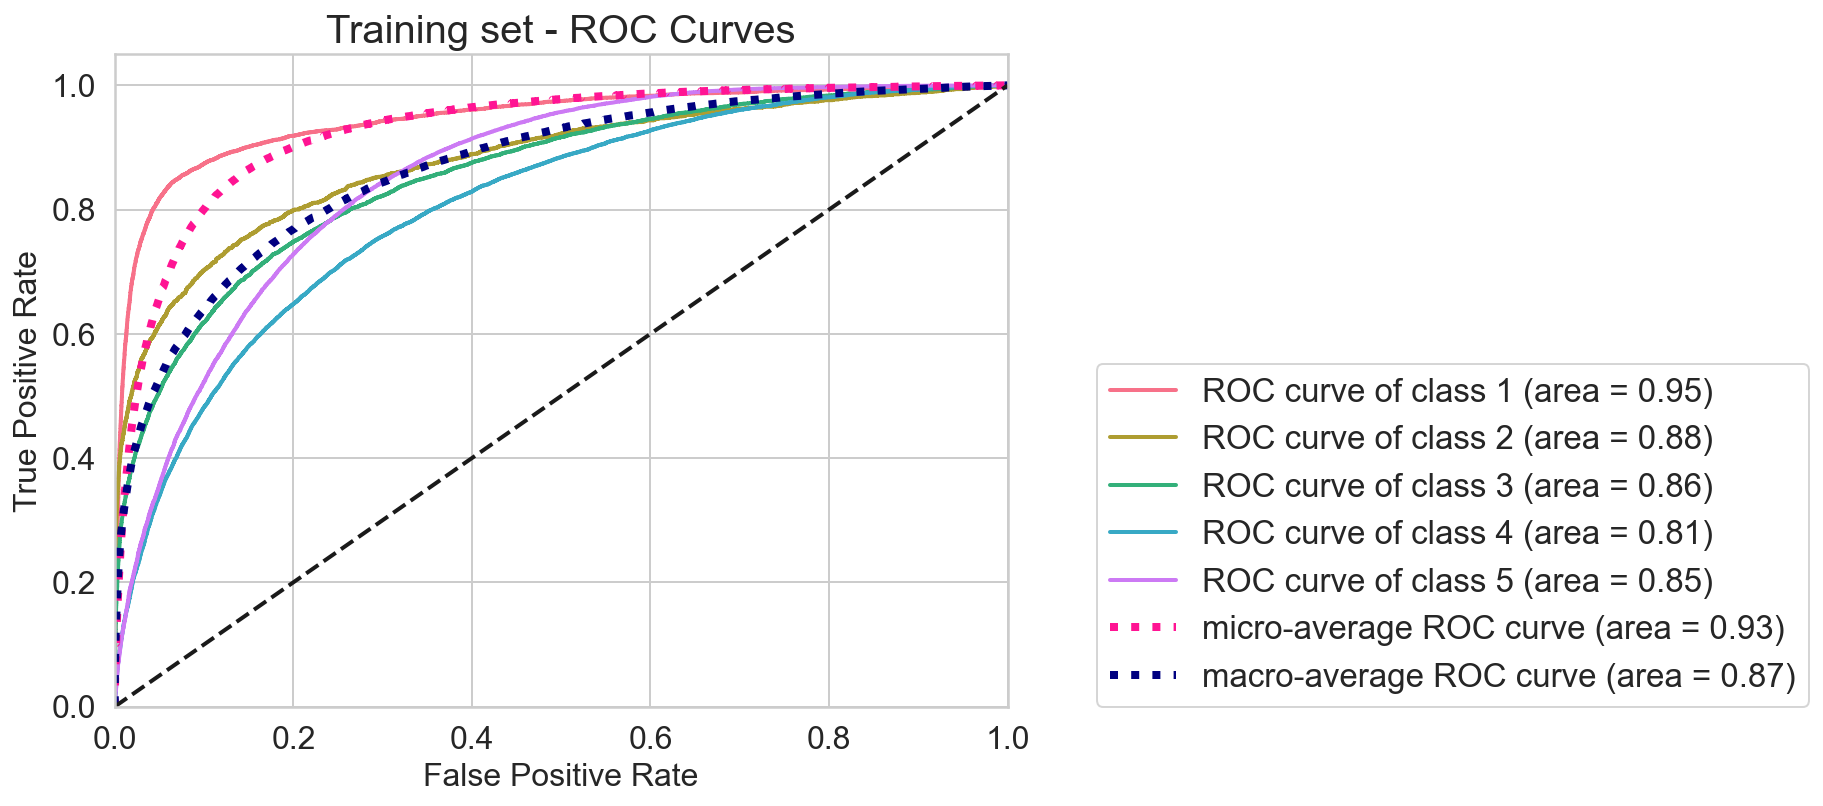

In [85]:
fig, ax = plt.subplots(figsize=(8,6))
skplt.metrics.plot_roc(y_train, y_train_pred_prob, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax=ax,
                       title='Training set - ROC Curves')
ax.legend(loc=[1.1,0])
plt.show()

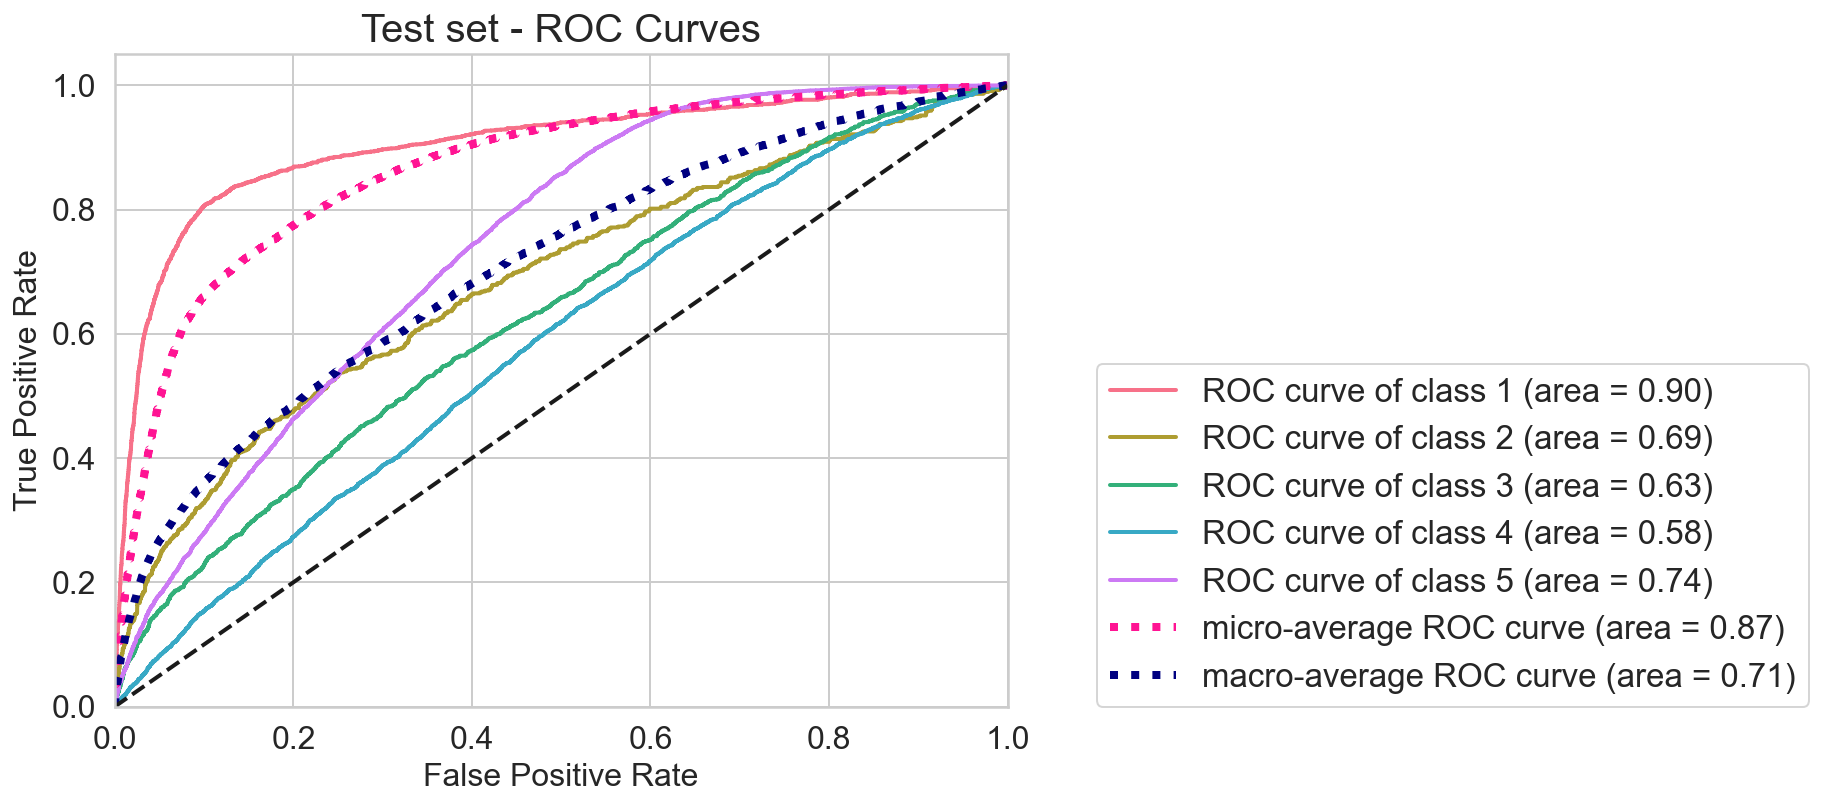

In [86]:
fig, ax = plt.subplots(figsize=(8,6))
skplt.metrics.plot_roc(y_test, y_test_pred_prob, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax=ax,
                       title='Test set - ROC Curves')
ax.legend(loc=[1.1,0])
plt.show()

### Coefficients
The image below shows that the NLP is by far the most important indicator for the prediction. The strongest not message feature is coming only at position 141.

In [87]:
#model_sgdc.get_params()

In [88]:
# getting features (numerical, categorical, review message)
features_onehot = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names().tolist()
features_word = preprocessor.transformers_[-1][1].named_steps['tfidf'].get_feature_names()
features_all = features_numerical + features_onehot + features_word

In [89]:
num_arr = np.array(len(features_numerical)*['numerical'])
cat_arr = np.array(len(features_onehot)*['categorical'])
word_arr = np.array(len(features_word)*['word'])
num_cat = np.append(num_arr, cat_arr)
feature_name_arr = np.append(num_cat, word_arr)

In [90]:
coefs_vars_sgdc = pd.DataFrame({
    'coef': model_sgdc.best_estimator_.coef_[0],
    'variable': features_all,
    'abscoef': np.abs(model_sgdc.best_estimator_.coef_[0]),
    'type': feature_name_arr
})

coefs_vars_sgdc.sort_values('abscoef', ascending=False, inplace=True)

In [91]:
coefs_vars_sgdc['translation'] = coefs_vars_sgdc[['variable']][:20] \
                                    .apply(lambda x: translator.translate(x[0]).text, axis=1)

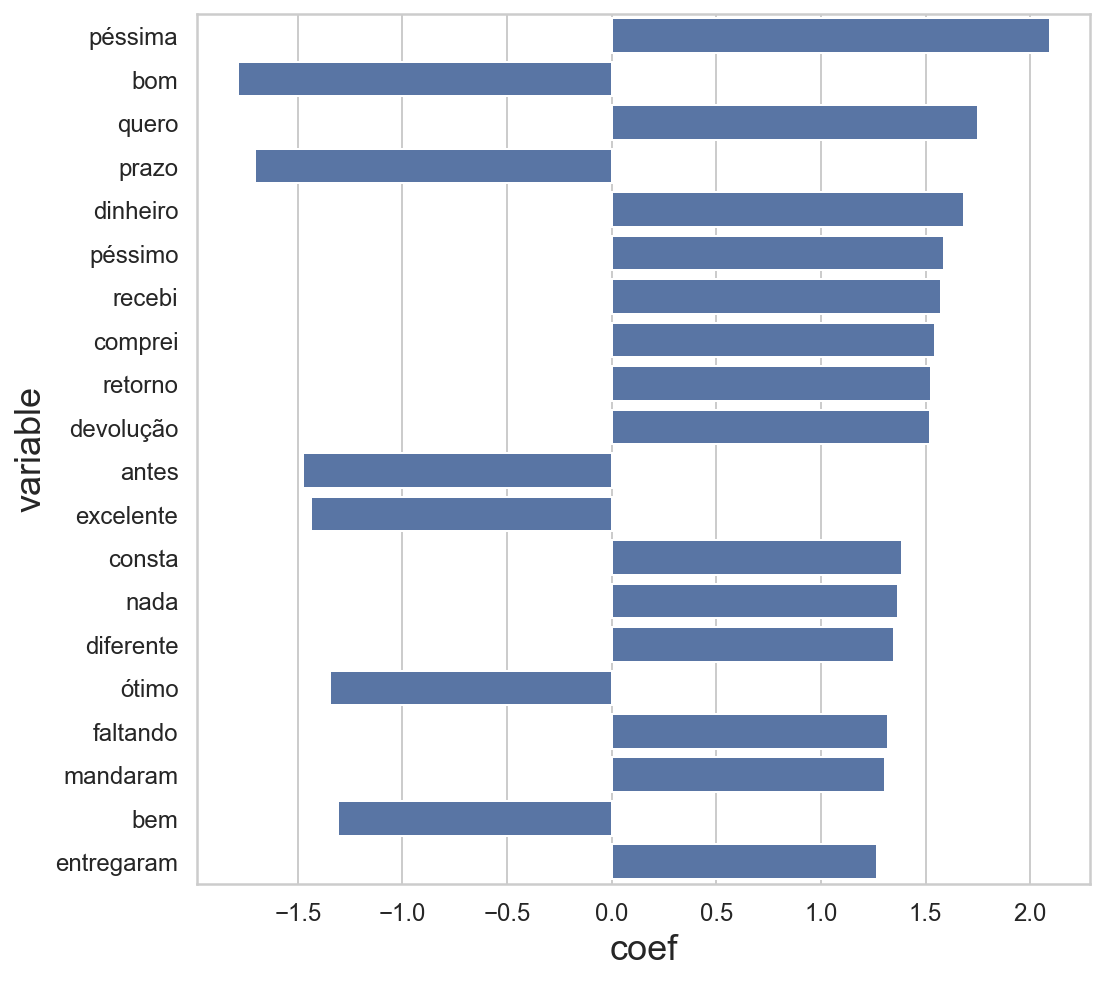

In [92]:
# strongest features 
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='variable', x='coef', data=coefs_vars_sgdc[:20],
            color='b', label='SGDC', ax=ax, orient='h')

plt.show()

In [93]:
coefs_vars_sgdc[['variable', 'translation']][:20]

,variable,translation
43430,péssima,lousy
37294,bom,good
43532,quero,I want
42970,prazo,deadline
39015,dinheiro,money
43433,péssimo,terrible
43697,recebi,I received
38092,comprei,I bought
44053,retorno,return
38940,devolução,devolution


In [94]:
# strongest none word feature (adding x0_, x1_, ... to the product names)
coefs_vars_sgdc.reset_index(drop=True, inplace=True)
none_word_feature = coefs_vars_sgdc.loc[coefs_vars_sgdc['type'] != 'word'].iloc[0]
print(f"""The strongest feature which doesn't belong to the review comment is called {none_word_feature['variable'].split('_')[1]} 
at position {none_word_feature.name}.""")

The strongest feature which doesn't belong to the review comment is called bee2e070c39f3dd2f6883a17a5f0da45 
at position 141.


### Conclusion
The baseline accuracy for the review scores lies at approximately {{'%.4f' % baseline}}. With the SGD Classifier could be accomplished a accuracy score of around {{'%.4f' % model_sgdc.best_score_}}. The model can detect the classes 1 and 5 easier than the scores between. Futhermore, the evaluation of the feature importance showed that the review messages have the highest impact to the classification.